## Cluster Finder

A quick, visual way to spot clusters in Gaia DR2 data, using distance, proper motion, and error cuts!

Instructions: Get Gaia DR2 Vizier data by querying Gaia DR2 (I/345), typing in some object or coordiantes, picking a search radius (I like 2 deg), selecting only distance rho and J2000 in the Vizier parameters on the left, deselecting all catalogue parameters, selecting Plx, e_Plx, pmRA, e_pmRA, pmDE, e_pmDE, Gmag, e_Gmag, BPmag, e_BPmag, RPmag, e_RPmag, RV, and e_RV, and outputting unlimited values as tab separated values file type. If you know the approximate distance range to your target range, you are encouraged to enter a rough, somewhat generous parallax range into Vizier, as this will greatly cut down on the perhaps irrelevant targets and make the data file way more manageable. The .tsv file should show up in your downloads folder (specify path in Setup below). Trim the file with the viztrim() function. Trimmed file will be saved to your data folder (also specify path in Setup below). Use plotcut() to try different cuts in color-coded distance and proper motions, which you can toggle. You can make cuts in error too, but I usually leave it as-is here. Keep cutting in plotcut() until you see a bunch of stars of roughly one color in distance, proper motion in RA, and proper motion in Dec. Refine the cuts, centering whatever color you see in your one-color blob. The blob may get more colorful again as you make closer cuts, but the random distribution of field stars should diminish. When you're happy with your surviving blob of stars, produce a data file of these stars' Gaia data and create a final plot using the finalcut function. Plot a Gaia DR2 BP-RP color-magnitude diagram of the stars using colmagBR(). Happy hunting!

If you use this code and find it helpful, please cite Yep & White 2022, in prep.

## Setup

In [11]:
#import Python stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import exists

#Your directories:
# defaults are blank if you don't mind putting everything into the same folder with
# this .ipynb file.
downdir='' #downloads folder, where Vizier will put the .tsv
ddir='' #where to access and save your data
pdir='' #where to save your plots

def viztrim(vizfilename,objname): #'vizier filename','object name'; expects filen of type .tsv in downloads folder; saves file in ddir as 'gaiasearch_objname.dat'
    f=open(downdir+vizfilename+'.tsv','r')       #objname could alternatively be a location name, e.g. coordinates.
    dat=f.readlines()                     #only have to run this once for each data set, just to generate nicely formatted data file without doing any work. :P
    f.close()                             #comment out viztrim stuff when you're done, to avoid rewriting your data files! Probably can prevent rewriting gaiasearch_etc, have to say 'y' or something.
    dt=[a[:2] for a in dat] #[:3] properly
    
    labind=dt.index('_r') #'_RA' properly
    try:
        datend=dt[int(2./3.*len(dt)):].index('#N')+int(2./3.*len(dt))-2 #assumes data set is reasonably long. If not, you can replace 2./3. with, say, 1./2. or less.
    except ValueError:
        datend=len(dt)-1
    print(labind,datend,'\n')
    pind=list(range(labind,labind+4))+list(range(datend-1,datend))
    for i in pind: #just to check it's right
        print(dat[i][:-1]) #just to check it's right
        if i==labind+3:
            print('...')
    print('---end---')
    
    if exists(ddir+'gaiasearch_'+objname+'.dat'):
        rewri=input("You've already trimmed Vizier Gaia DR2 data for this object name. Rewrite? 'y'/'n'\n")
        if rewri=='y':
            f=open(ddir+'gaiasearch_'+objname+'.dat','w')
            print('#'+dat[labind][:-1],file=f)
            for d in dat[labind+3:datend]:
                print('\t'.join(d[:-1].split('\t')),file=f) #to keep tabs and get rid of extra line break
            f.close()
            print('File rewritten.')
        else:
            print('File NOT rewritten.')
    else:
        f=open(ddir+'gaiasearch_'+objname+'.dat','w')
        print('#'+dat[labind][:-1],file=f)
        for d in dat[labind+3:datend]:
            print('\t'.join(d[:-1].split('\t')),file=f) #to keep tabs and get rid of extra line break
        f.close()

#open Gaia DR2 file, pt. 1
def opendatg(objname): #'filename'. For opening a data file in ddir.
    f=open(ddir+'gaiasearch_'+objname+'.dat','r')
    dat=f.readlines()
    f.close()
    labels=dat[0][0:-1].split()
    dat2=[[a.strip('\n') for a in d.split('\t')] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

#open Gaia DR2 file, pt. 2
def opendat2g(objname,params): #Use as var,var,var...=opendat2(dir,'filename',['keys']).
    dat,label=opendatg(objname)  #Get keys by first leaving ['keys'] blank: opendat2(objname,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

#Regular opendat that I use:
def opendat(dir,filename): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    labels=dat[0][0:-1].split()
    dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]
def opendat2(dirr,filename,params): #Use as var,var,var...=opendat2(dir,'filename',['keys']).
    dat,label=opendat(dirr,filename)  #Get keys by first leaving ['keys'] blank: opendat2(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

#Exploratory Cuts
#Doesn't save anything, just lets you look around. Do so until you're happy and then shove parameters into Final Cut. :)
#Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode
def plotcut(objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,Color): #colorcode by Color param: 'dist', 'pra', 'pdec'    
    print("input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode\n")
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=opendat2g(objname,('_RAJ2000', '_DEJ2000','Plx', 'e_Plx','pmRA', 'e_pmRA', 'pmDE', 'e_pmDE','Gmag', 'e_Gmag','BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV'))
    #Vizier params:
    print('\nVizier search params (deg):\nRA:',(np.max(ra)+np.min(ra))/2.,'\nDec:',(np.max(dec)+np.min(dec))/2.,'\nRadius:',(np.max(dec)-np.min(dec))/2.)
    print('original length:',len(p))
    
    pmin,pmax=1000./dmax,1000./dmin
    pars=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr]
    PARS=[]
    for par in pars:
        PAR=[par[i] for i in range(len(p)) if p[i]<pmax and p[i]>pmin and pra[i]<pramax and pra[i]>pramin and pdec[i]<pdecmax and pdec[i]>pdecmin and perr[i]<perrmax and praerr[i]<pmerrmax and pdecerr[i]<pmerrmax]
        PARS.append(PAR)
    #return PARS
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr=PARS
    print('Cut length:',len(p))
    
    if Color=='dist':
        D,clab=1000./np.array(p),'$d$ (pc)' #distance
    if Color=='pra':
        D,clab=pra,'$\mu_{\\alpha}$ (mas/yr)' #pra
    if Color=='pdec':
        D,clab=pdec,'$\mu_{\delta}$ (mas/yr)' #pdec
    
    cmin=np.nanmin(D)
    cmax=np.nanmax(D) #capping it here for colorcoding
    precvrs=[(c-cmin)/(cmax-cmin) for c in D]
    CC=[plt.cm.rainbow(v) for v in precvrs]

    plt.figure(figsize=(12,10))
    plt.title(objname.upper()+' Region')
    plt.scatter(ra,dec,color=CC,s=25)  #s=50 for pres, 25 otherwise, or blank is fine.
    plt.xlim(np.max(ra)+0.1,np.min(ra)-0.1)
    plt.ylim(np.min(dec)-0.1,np.max(dec)+0.1)
    plt.ylabel('Dec ($^{\circ}$)')
    plt.xlabel('RA ($^{\circ}$)')    #plt.xlim(121,125)
    #plt.ylim(-35,-37)
    colors = plt.cm.rainbow(D)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=cmin, vmax=cmax))
    # fake up the array of the scalar mappable. Urgh…
    sm._A = []
    cbar=plt.colorbar(sm,pad=0.01)
    cbar.set_label(label=clab)
    return (objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax)

#Final Cut
#Exports data file. You can add to plot as necessary. When you like it, you can save it.
#plt.legend(fontsize=10,scatterpoints=1,loc=4)
#plt.savefig(pdir+'gaiacands_'+objname+'_l'+str(magmax)+'.png')
#pars output from plotcut,RA Dec window,brighter-than-mag to mark]

def finalcut(pars,ramin,ramax,decmin,decmax): #box cut, from refining plotcut above.
    print("input: pars output from plotcut,RA Dec window,brighter-than-mag to mark\n")
    objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax=pars
    
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=opendat2g(objname,('_RAJ2000', '_DEJ2000','Plx', 'e_Plx','pmRA', 'e_pmRA', 'pmDE', 'e_pmDE','Gmag', 'e_Gmag','BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV'))
    print('original length:',len(p))
    
    pmin,pmax=1000./dmax,1000./dmin
    pars=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr]
    PARS=[]
    for par in pars:
        PAR=[par[i] for i in range(len(p)) if p[i]<pmax and p[i]>pmin and pra[i]<pramax and pra[i]>pramin and pdec[i]<pdecmax and pdec[i]>pdecmin and perr[i]<perrmax and praerr[i]<pmerrmax and pdecerr[i]<pmerrmax and ra[i]<ramax and ra[i]>ramin and dec[i]<decmax and dec[i]>decmin]
        PARS.append(PAR)
    #return PARS
    ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr=PARS
    count=len(p)
    print('Cut length:',count)
    
    lab=('#ra', 'dec','p', 'perr','pra', 'praerr', 'pdec', 'pdecerr','G', 'Gerr','BP','BPerr','RP','RPerr','rv','rverr')
    ds=[ra,dec,p,perr,pra,praerr,pdec,pdecerr,G,Gerr,B,Berr,R,Rerr,rv,rverr]
    dsp=[[str(d[i]) for d in ds] for i in range(len(ra))]

    f=open(ddir+'gaiacands_'+objname.upper()+'.dat','w')
    print(' \t '.join(lab),file=f)
    for d in dsp:
        print(' \t '.join(d),file=f)
    f.close()
    
    print('\nSaved data to '+ddir+'gaiacands_'+objname.upper()+'.dat.\n')
    
    print('G mag:',np.min(G),'-',np.max(G),', straight mean',np.mean(G))
    mask=np.array(G)<magmax

    PARS=plotcut(objname,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,'dist')
    plt.ylim(decmin,decmax)
    plt.xlim(ramax,ramin)
    plt.legend(fontsize=10,scatterpoints=1)
    #plt.savefig(pdir+objname+'_gaiacands_l'+str(magmax)+'.png')
    
    return objname,ramin,ramax,decmin,decmax,dmin,dmax,pramin,pramax,pdecmin,pdecmax,perrmax,pmerrmax,count

#Color-Magnitude Diagaram
#Plot a rough Gaia BP-RP vs. BP color-magnitude diagram of your stars
def colmagBR(objname,dist):
    print('input: Object name, average distance to potential cluster, save plot y or n')
    p,perr,G,Gerr,B,Berr,R,Rerr=opendat2(ddir,'gaiacands_'+objname+'.dat',('p', 'perr','G', 'Gerr','BP','BPerr','RP','RPerr')) #maybe add add-nan capability for blank slots!
    
    plt.figure(figsize=(10,6))
    
    plt.scatter(np.array(B)-np.array(R),B,s=25) #s=50 for pres
    plt.xlabel('BP-RP')
    plt.ylabel('BP')
    plt.ylim(np.nanmax(B)+0.3,np.nanmin(B)-0.3)
    plt.legend(fontsize=12)
    
    #plt.savefig(ddir+'gaiacolormag_'+objname+'.png')

Files: Either place .tsv file from Vizier into same folder with ClusterFinder.ipynb, or specificy .tsv location in the downdir='' slot. File will be saved as gaiacands_OBJECTNAME.dat in ddir location.

In [8]:
objname='cluster1' #specify your object name. For example, cluster1.
viztrim('asu (22)',objname)

75 60427 

_r	_RAJ2000	_DEJ2000	Plx	e_Plx	pmRA	e_pmRA	pmDE	e_pmDE	Gmag	e_Gmag	BPmag	e_BPmag	RPmag	e_RPmag	RV	e_RV
deg	deg	deg	mas	mas	mas/yr	mas/yr	mas/yr	mas/yr	mag	mag	mag	mag	mag	mag	km/s	km/s
--------	-----------------	-----------------	----------	-------	---------	------	---------	------	-------	------	-------	------	-------	------	-------	-----
0.004617	122.3691917771334	-47.3382833766821	    2.9506	 0.0197	   -6.349	 0.031	    9.398	 0.034	13.8220	0.0027	14.3293	0.0236	12.9770	0.0101	       	
...
2.999980	124.2436383136909	-44.6307109314584	    4.3926	 1.8457	    2.486	 2.233	    7.541	 3.275	20.4842	0.0130	20.5040	0.1703	19.0355	0.0838	       	
---end---
You've already trimmed Vizier Gaia DR2 data for this object name. Rewrite? 'y'/'n'
n
File NOT rewritten.


input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode

['#_r', '_RAJ2000', '_DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV']

Vizier search params (deg):
RA: 122.3750389198108 
Dec: -47.334371408962554 
Radius: 2.9983703330902465
original length: 60349
Cut length: 184


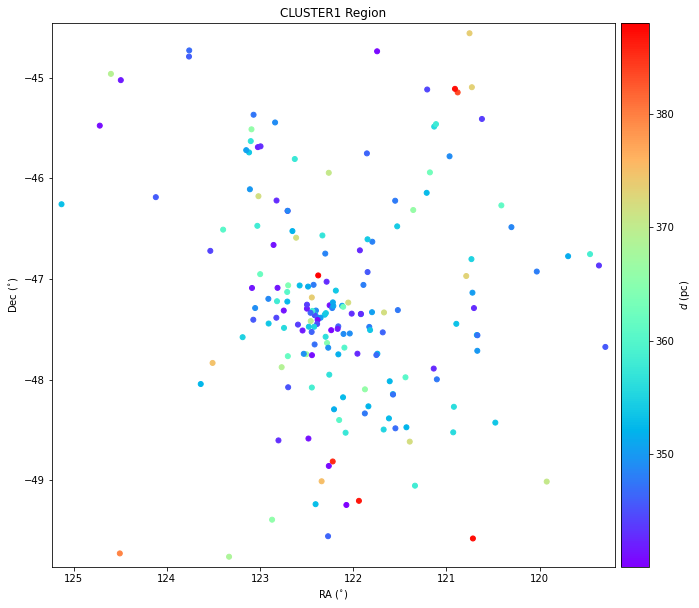

In [10]:
cluster1pars=plotcut(objname,340.,390.,-8.5,-5.,9.5,12.5,0.1,0.16,'dist') #using median errors for G mag 17 as detailed in Appendix C of Lindegren et al. 2018

input: pars output from plotcut,RA Dec window,brighter-than-mag to mark

['#_r', '_RAJ2000', '_DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV']
original length: 24324
Cut length: 16

Saved data to /Users/Cougy/gsu-thesis/Research/PythonPlots/data2/gaiacands_CG30TEST.dat.

G mag: 12.6049 - 17.1479 , straight mean 15.4666
Stars brighter than mag 15: 5 

input: Object name, distance min + max, proper motion RA min + max, propermotion Dec min + max, parallax error max, proper motion error max, parameter to colorcode

['#_r', '_RAJ2000', '_DEJ2000', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'RV', 'e_RV']

Vizier search params (deg):
RA: 122.38980003109005 
Dec: -36.085690234135654 
Radius: 1.995752920847952
original length: 24324
Cut length: 27


('CG30test',
 121.7,
 123.3,
 -37.2,
 -35.75,
 340.0,
 390.0,
 -8.5,
 -5.0,
 9.5,
 12.5,
 0.1,
 0.16,
 16)

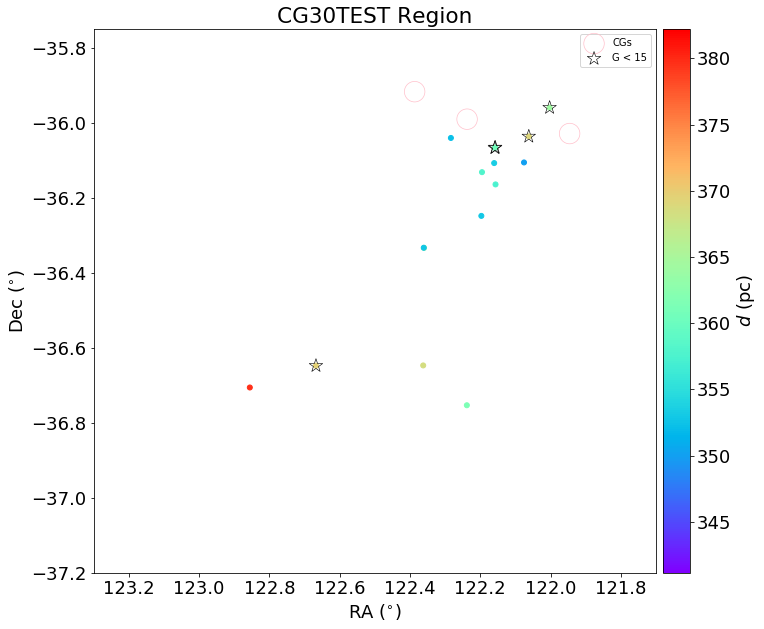

In [37]:
finalcut(UPK533pars,121.7,123.3,-37.2,-35.75,15)

input: Object name, average distance to potential cluster, save plot y or n
['#ra', 'dec', 'p', 'perr', 'pra', 'praerr', 'pdec', 'pdecerr', 'G', 'Gerr', 'BP', 'BPerr', 'RP', 'RPerr', 'rv', 'rverr']


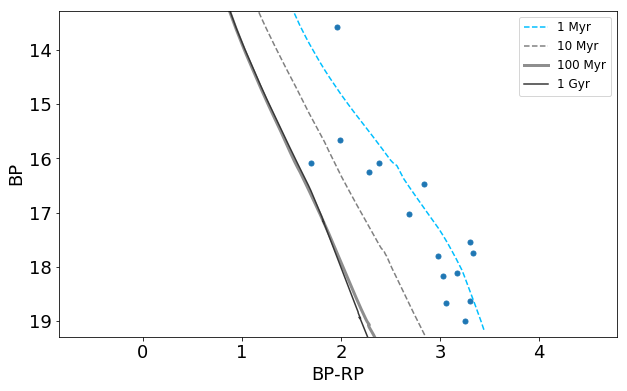

In [38]:
colmagBR('UPK533',361.8)

"Hi Azmain, and anyone else interested,

     I have developed a quick, visual, empirical way to search for star clusters (or associations etc.) using Python and tab-separated-value Gaia DR2 data from Vizier. You simply input parallax cuts, proper motion cuts, and max parallax and proper motion errors, and poof! You get an RA-Dec plot of your Gaia DR2 data, color-coded for distance, proper motion in RA, or proper motion in Dec, your pick, toggle at will. If you see a glob of stars that appear to be of one color, boom! You may have just found a cluster! Pretty groovy. You can then plot a color-magnitude diagram of your possible cluster members using Gaia BP and RP mags. Note that the weird scattered dim stuff at the bottom of the main sequence might be Gaia garbage, which can be reduced with stricter error cuts.
     Color map is currently set to rainbow, which you can change to whatever other Python color map you prefer. I just chose the one with maximum pretty colors! It's also important that the shades gradate evenly. Anyway...enjoy! I hope this little tool might be useful to you. If you have any questions about it or would like a personal tour of the code, please don't hesitate to ask me. :)
     I work in Jupyter Notebook and recommend you do the same, but if you don't, I've attached the bare code as well. There's also a sample Vizier data file, asu (16)_CG30.tsv. Stick it in your downloads, stick the Padova isochrones in your chosen data directory, and set all the directory paths as necessary. Then give it a go!

Happy hunting!
- Alexandra Yep"